In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats

import plot_utils as pu
import styling

import conf.isi5_sweep as cfg

In [2]:
def index(n0, n1):
    return ((n0-n1)/(n0+n1))

In [3]:
def label(STD, TA):
    if STD and TA:
        return 'STD+TA (full model)'
    elif STD:
        return 'STD only'
    elif TA:
        return 'TA only'
    return 'no plasticity'

In [4]:
def get_bspikes(res, episode):
    b = np.zeros(np.asarray(res['raw_dynamics']['v'].shape)[[0,2,3]], bool)
    for itrial, (i, spike_t) in enumerate(zip(*[res['raw_spikes'][episode][f'pulsed_{k}'] for k in 'it'])):
        t = (spike_t / cfg.params['dt'] + .5).astype(int)
        b[i, itrial, t] = True
    return b

In [5]:
plasticity = [(TA, STD) for TA in cfg.TAs for STD in cfg.STDs][1:]
colors = ['C1', 'C2', 'C0', 'k']

In [6]:
nspikes = dd.io.load('nspikes.h5')

ISI = 50: z = -9.5, p = 1.97e-21
ISI = 100: z = -8, p = 8.99e-16
ISI = 200: z = -0.01, p = 0.992
ISI = 350: z = -3.4, p = 0.000736
ISI = 500: z = -3.9, p = 9.03e-05
ISI = 750: z = -2.1, p = 0.0376
ISI = 1000: z = -0.38, p = 0.7


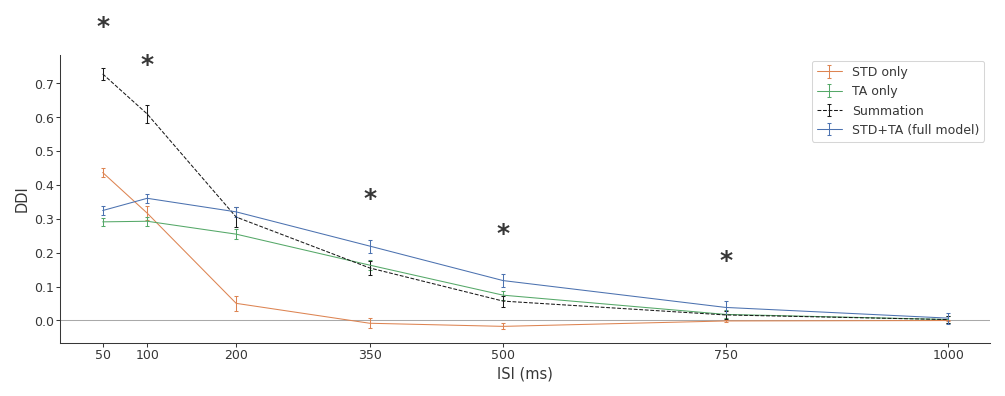

In [7]:
def panel_isi(ax):
    # ddi: (plasticity, isi, network)
    ddi = np.asarray([[index(nspikes[isi][STD][TA]['dev'], nspikes[isi][STD][TA]['msc']) for isi in cfg.ISIs] for TA, STD in plasticity])
    ddi = np.concatenate([ddi[:2], [ddi[0]+ddi[1]], ddi[2:]])
    labels = ['STD only', 'TA only', 'Summation', 'STD+TA (full model)']
    colors = ['C1', 'C2', 'k', 'C0']
    ymax = [0 for isi in cfg.ISIs]
    for i, pidx in enumerate(ddi):
        mean = np.mean(pidx, 1)
        se = np.std(pidx, 1) / np.sqrt(pidx.shape[1])
        ax.errorbar(cfg.ISIs, mean, yerr=se, label=labels[i], color=colors[i], ls='--' if i ==2 else '-', capsize=1, capthick=.5)
        ymax = np.maximum(ymax, mean+se)
    
    for i, isi in enumerate(cfg.ISIs):
        test = stats.wilcoxon(ddi[2, i], ddi[3, i], method='approx')
        print(f'ISI = {isi}: z = {test.zstatistic:.2g}, p = {test.pvalue:.3g}')
        if test.pvalue < .05:
            ax.text(isi, ymax[i]+0.1, '*', ha='center', **styling.label_kwargs)
    
    ax.axhline(0, **styling.axline_kwargs)
    ax.legend()
    ax.set_xticks(cfg.ISIs)
    ax.set_xlabel('ISI (ms)')
    ax.set_ylabel('DDI')
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(pu.fullwidth(2)), dpi=150)
panel_isi(ax)
plt.savefig('paper1/fig-isi.pdf')